In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
import pywt

In [2]:
def wavelet_denoise(ecg_signal, wavelet="db4", level=3):
    """
    Apply wavelet denoising to a 12-lead ECG signal.

    Parameters:
    - ecg_signal: numpy array of shape (12, 500)
    - wavelet: the type of wavelet to use (default is 'db4')
    - level: level of decomposition (default is 3)

    Returns:
    - denoised_ecg: numpy array of the denoised ECG signal with the same shape as the input
    """
    denoised_ecg = np.zeros_like(ecg_signal)
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(ecg_signal)))
    denoised_coeffs = [pywt.threshold(c, threshold, mode="soft") for c in coeffs]
    denoised_ecg = pywt.waverec(denoised_coeffs, wavelet)

    return denoised_ecg

In [3]:
PERIOD = 5_000

In [4]:
original = pd.read_csv("beijing_temperature.csv", header=None).to_numpy()[1]
original

array([-29, -29, -34, ..., 146, 166, 171])

In [5]:
baseline = np.mean(original)
baseline

3.8228

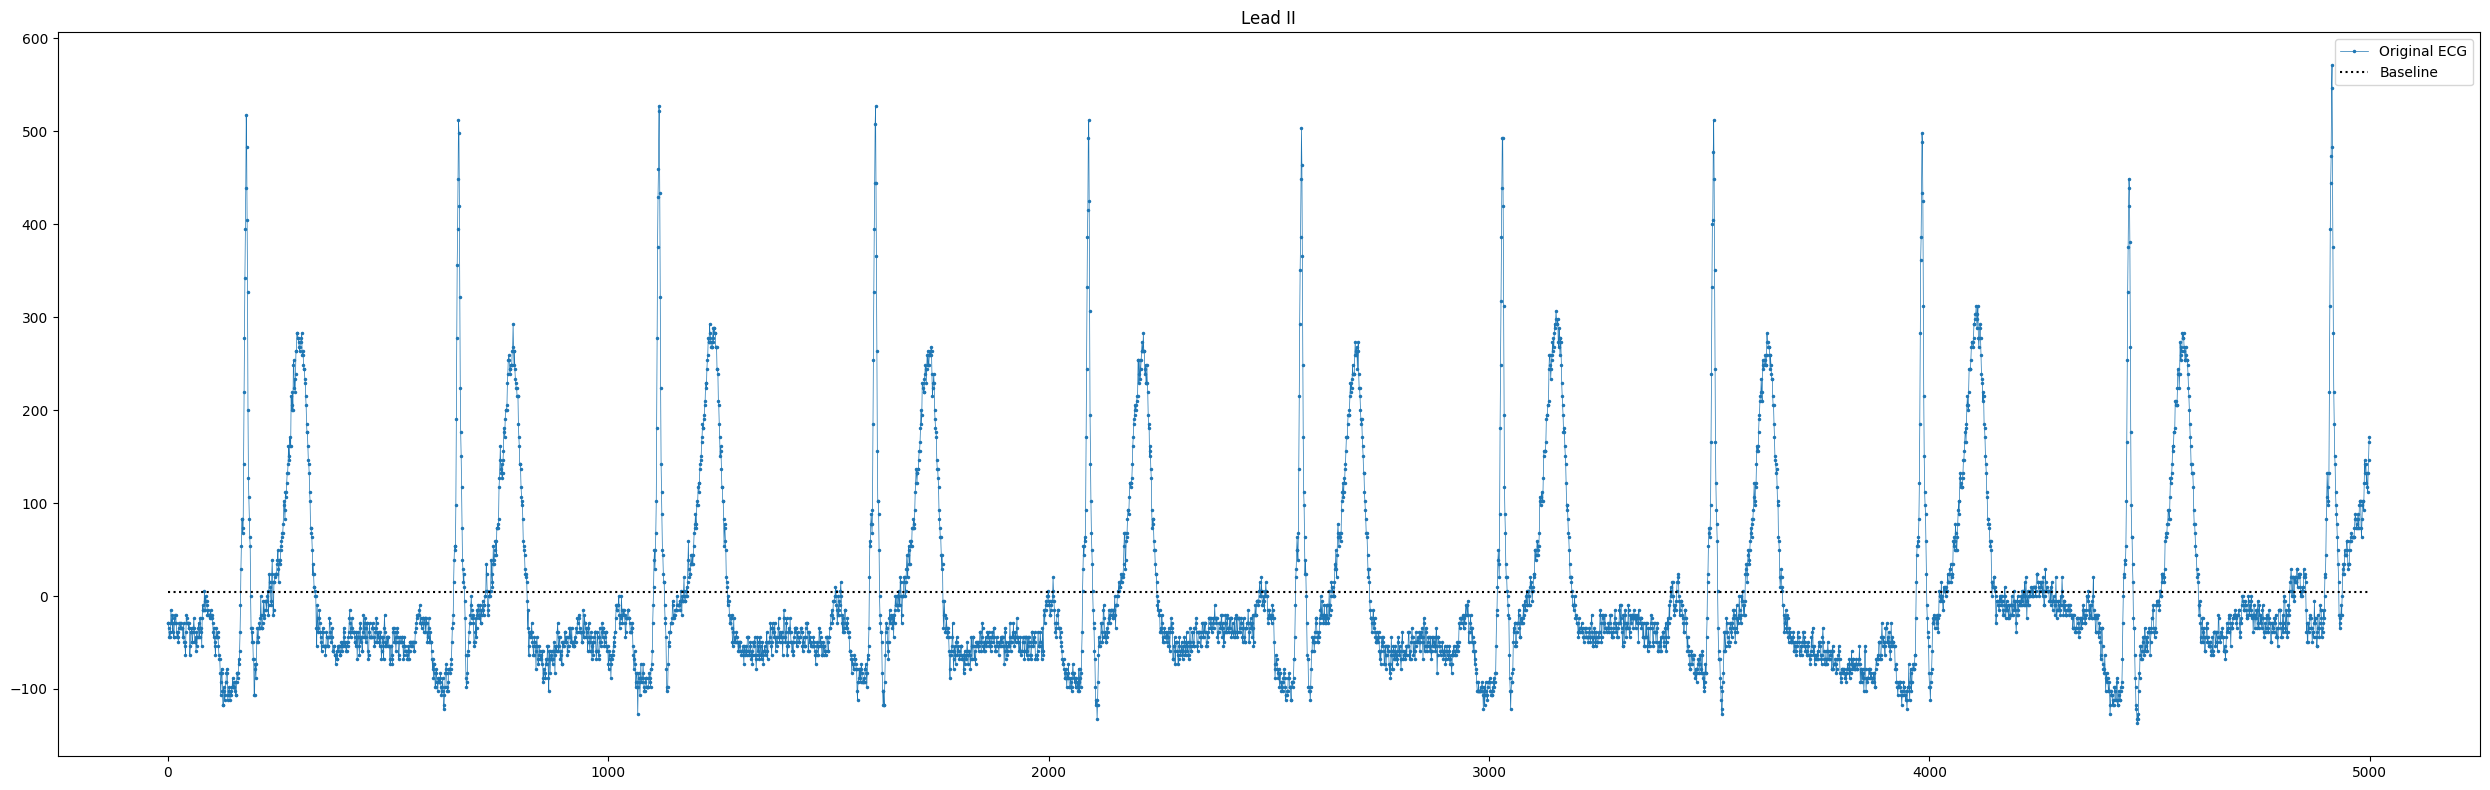

In [6]:
plt.figure(figsize=(25, 8))
plt.plot(original[:5000], '.-', linewidth=0.5, markersize=3, label="Original ECG")
plt.hlines(baseline, 0, 5000, linestyles="dotted", colors="black", label="Baseline")
plt.title(f"Lead II")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f"original_ecg_m.pdf")
plt.show()

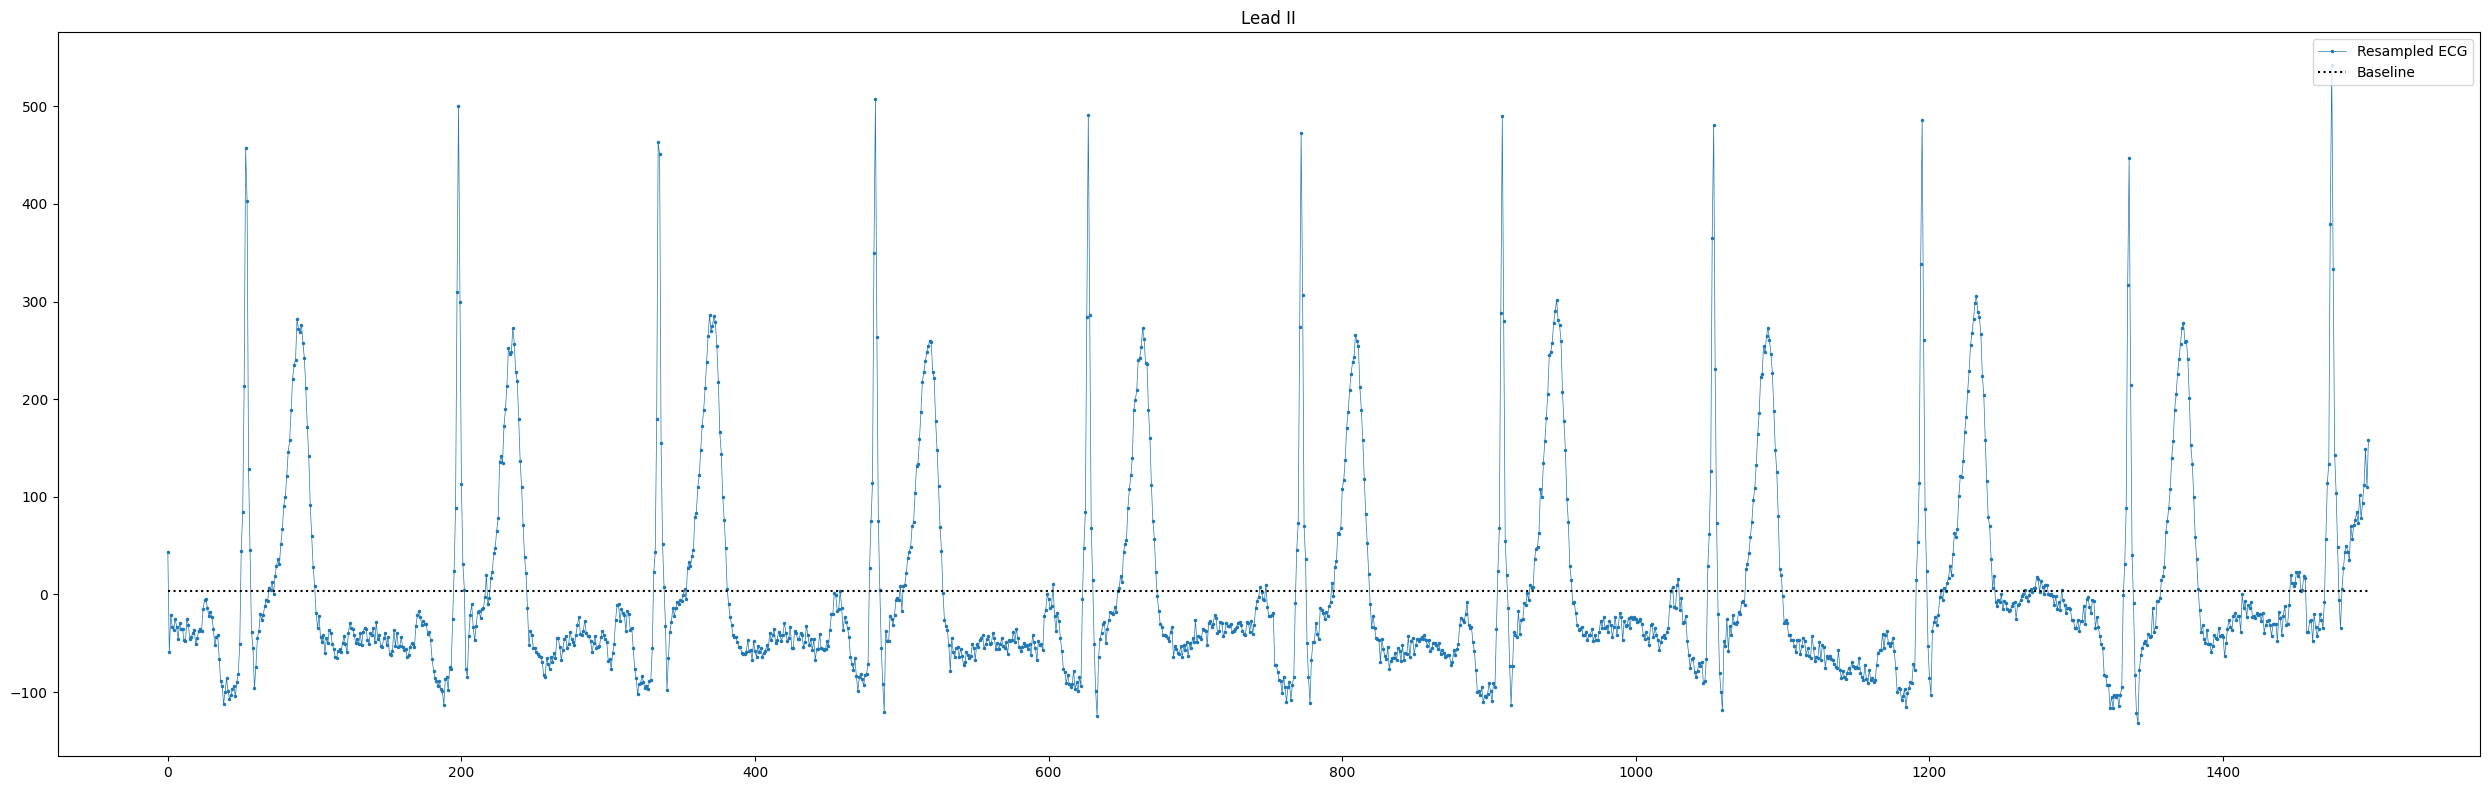

In [7]:
original = resample(original, 1500)
original = np.round(original).astype(int)
baseline = np.mean(original)
plt.figure(figsize=(25, 8))
plt.plot(original, '.-', linewidth=0.5, markersize=3, label="Resampled ECG")
plt.hlines(baseline, 0, len(original), linestyles="dotted", colors="black", label="Baseline")
plt.title("Lead II")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f"resampled_ecg_m.pdf")
plt.show()

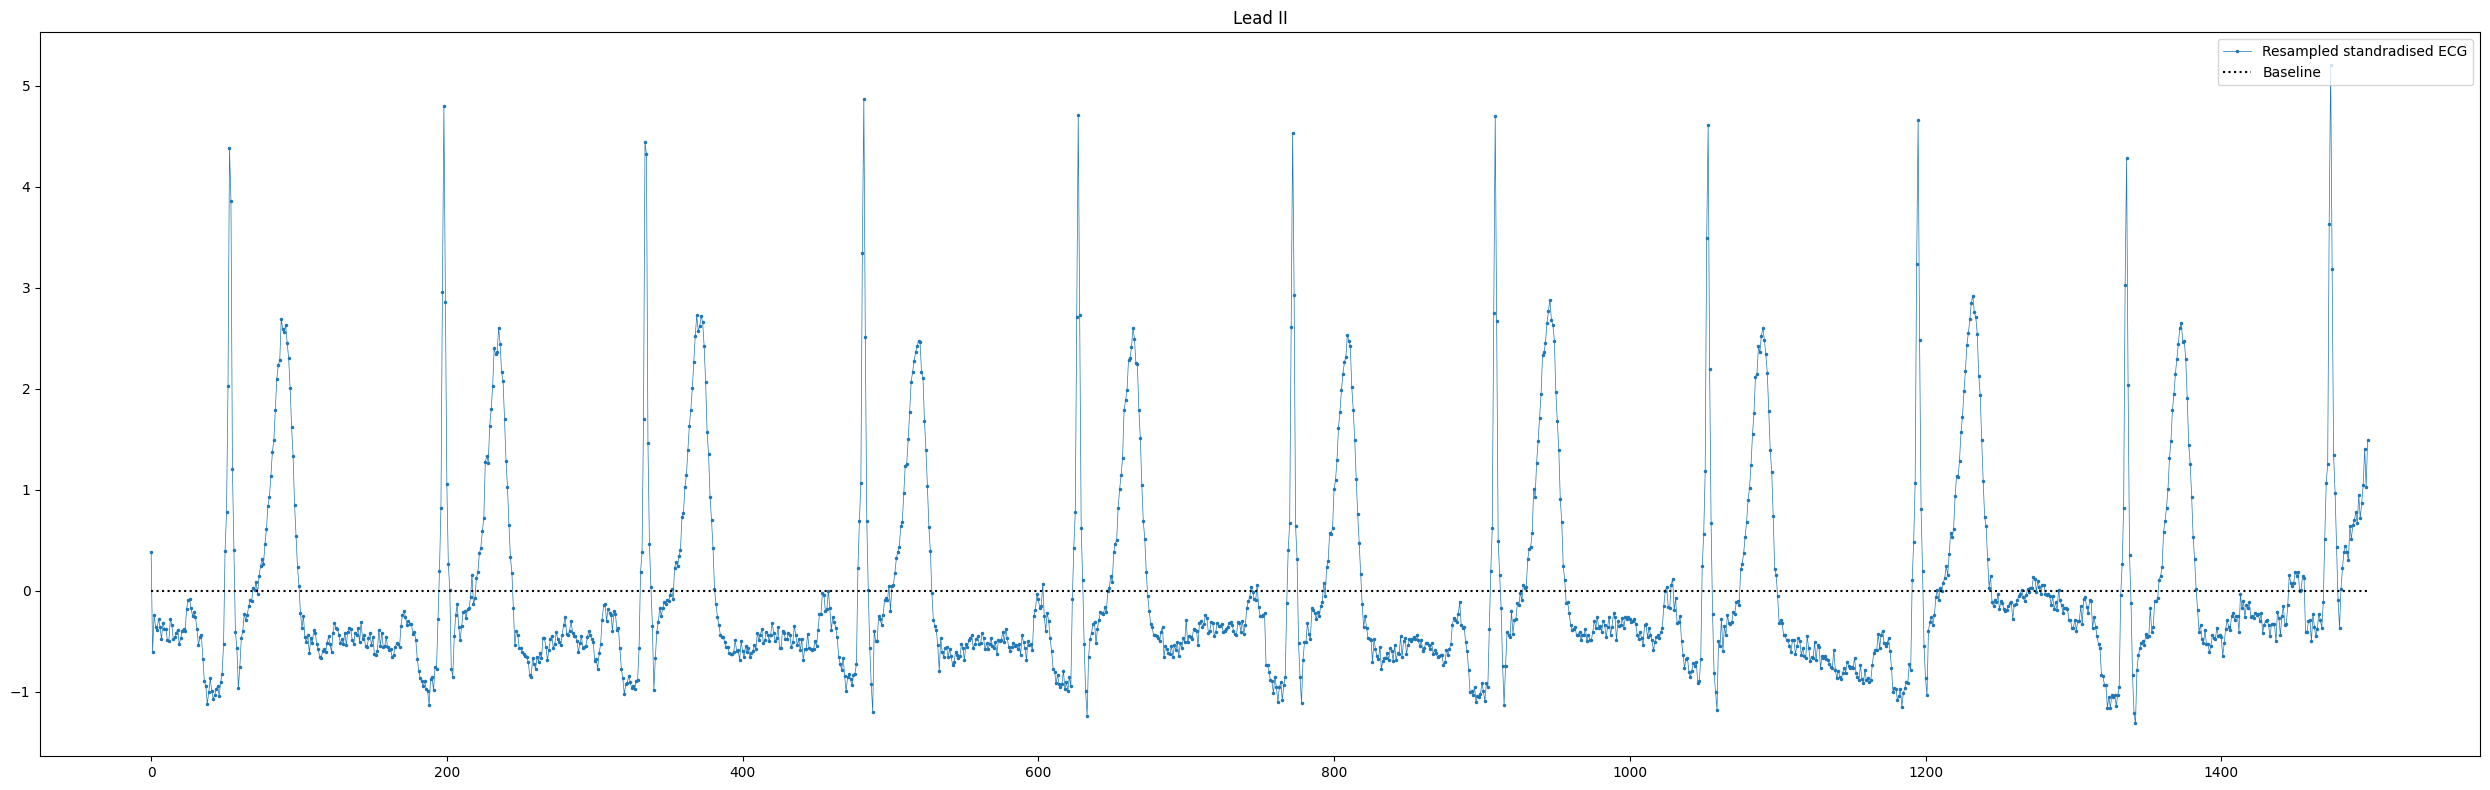

In [8]:
original = ((original.T - original.T.mean(axis=0)) / (original.T.std(axis=0))).T
baseline = np.mean(original)
plt.figure(figsize=(25, 8))
plt.plot(original, '.-', linewidth=0.5, markersize=3, label="Resampled standradised ECG")
plt.hlines(baseline, 0, len(original), linestyles="dotted", colors="black", label="Baseline")
plt.title("Lead II")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f"resampled_standardised_ecg_m.pdf")
plt.show()

In [9]:
Y = pd.read_csv("beijing_temperature.csv", header=None).to_numpy()[1]
Y

array([-29, -29, -34, ..., 146, 166, 171])

In [10]:
Y = resample(Y, 1500)
Y = np.round(Y).astype(int)
Y = Y[:PERIOD]
Y = wavelet_denoise(Y, wavelet="db4", level=None)
Y = ((Y.T - Y.T.mean(axis=0)) / (Y.T.std(axis=0))).T
baseline = np.mean(Y)
Y.shape

(1500,)

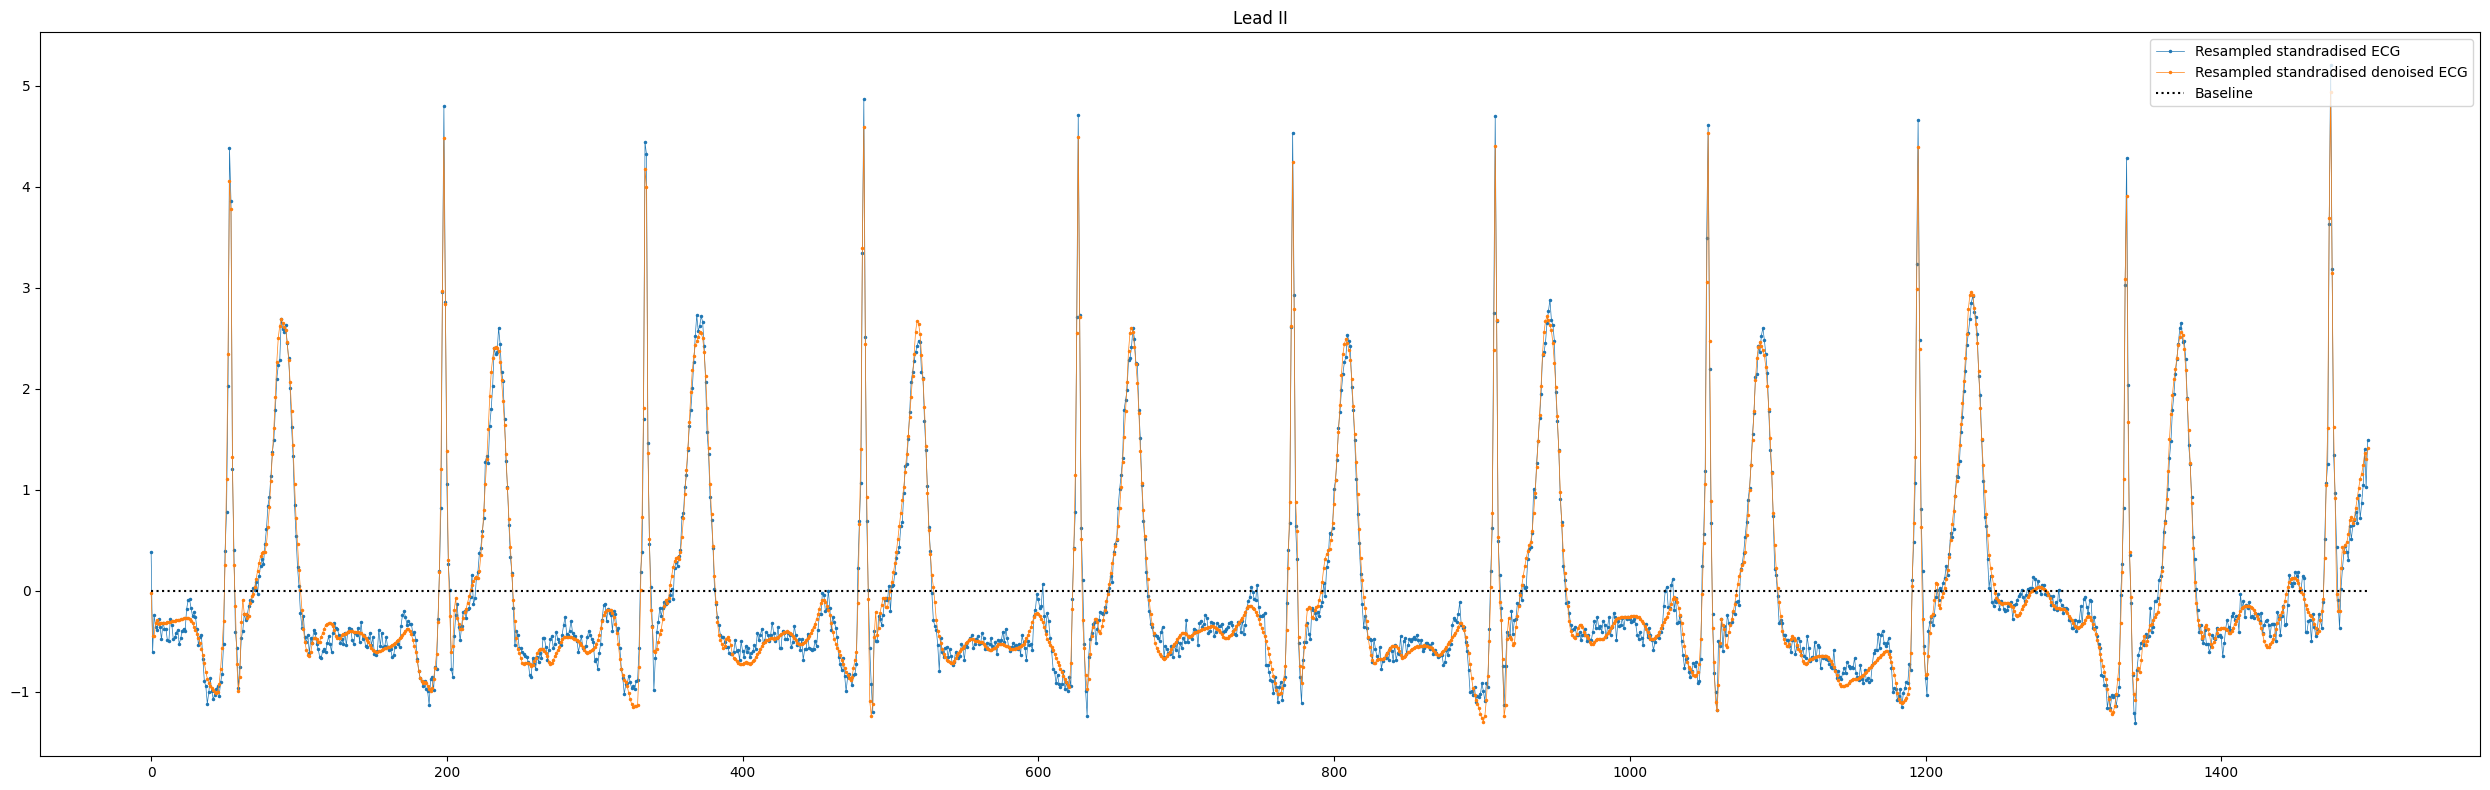

In [11]:
plt.figure(figsize=(25, 8))
plt.plot(original, '.-', linewidth=0.5, markersize=3, label="Resampled standradised ECG")
plt.plot(Y, '.-', linewidth=0.5, markersize=3, label="Resampled standradised denoised ECG")
plt.hlines(baseline, 0, len(original), linestyles="dotted", colors="black", label="Baseline")
plt.title("Lead II")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f"resampled_standardised_denoised_ecg_m.pdf")
plt.show()

In [12]:
rec = pd.read_csv("/Users/ljoana/repos/rPSMF/5000s_r3_n3_100it_wavelet_stand_10test.csv", header=None).to_numpy()[1]
rec

array([-0.35790823, -0.48364088, -0.60885387, ..., -0.25750158,
       -0.05597886,  0.13244151])

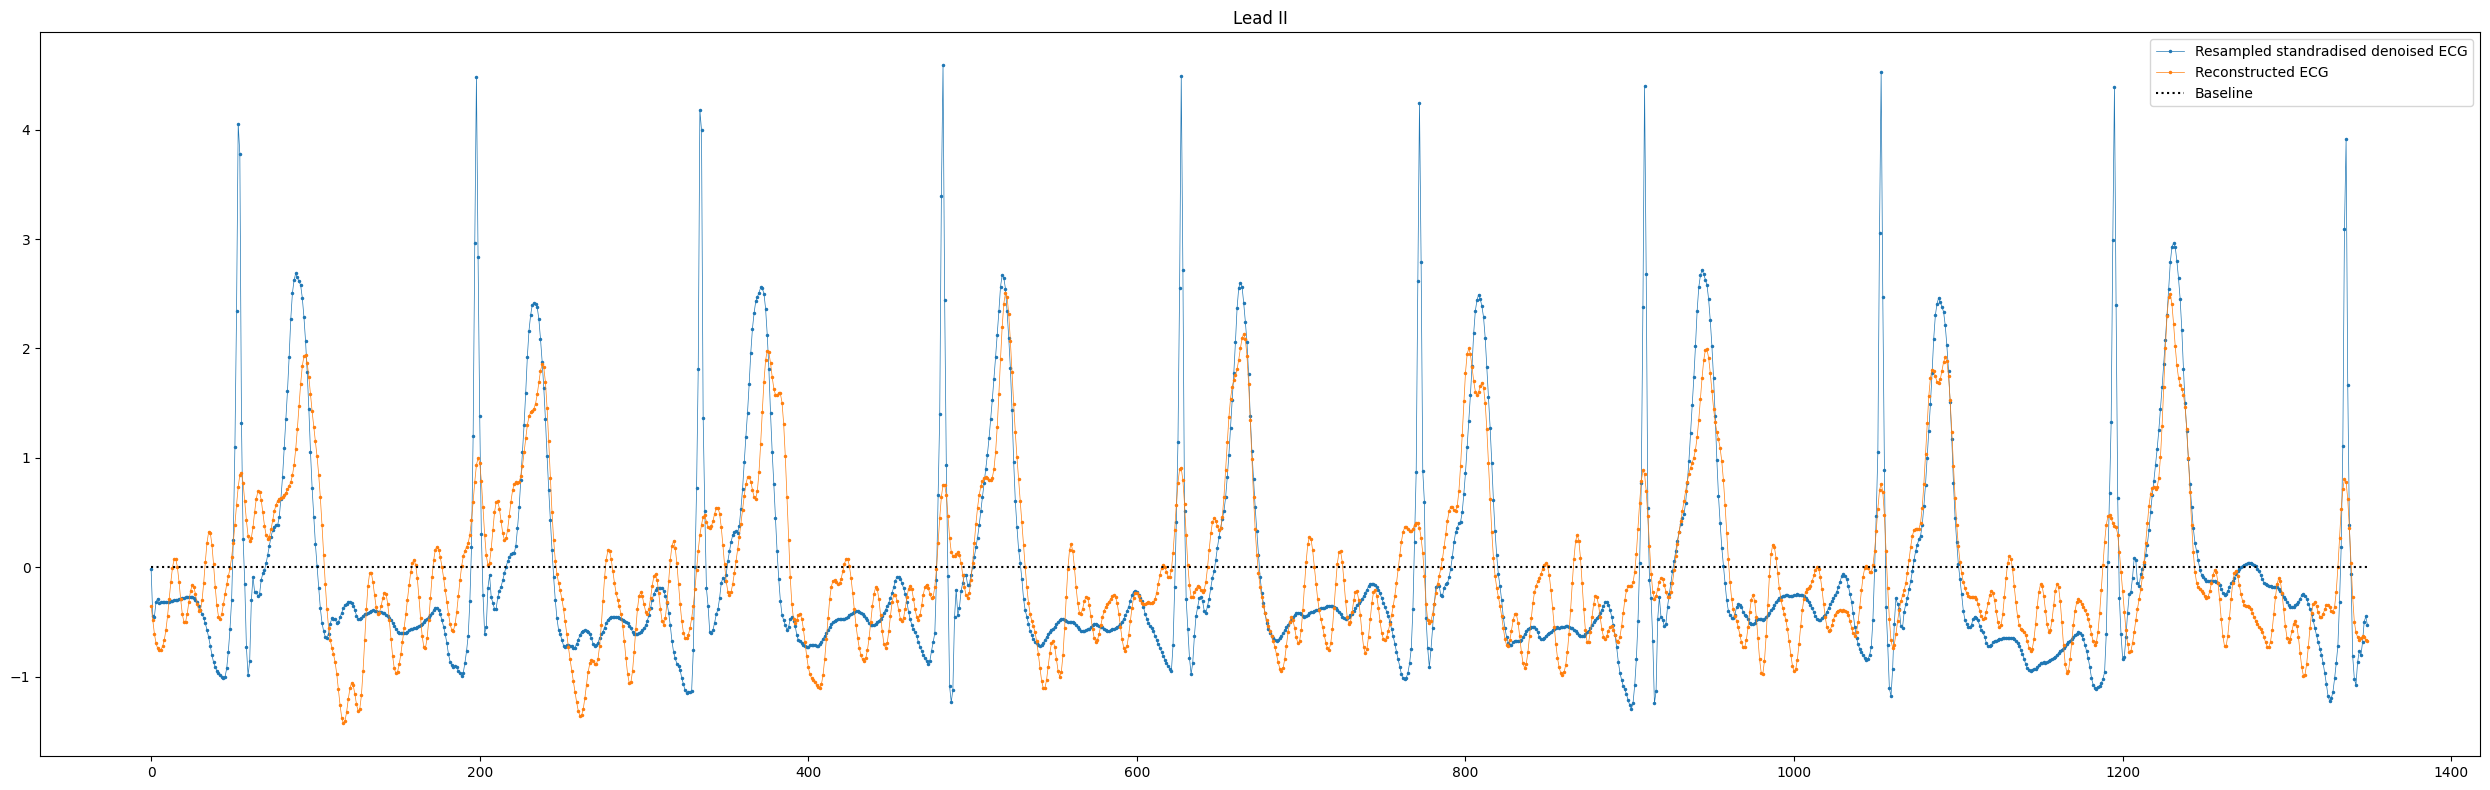

In [13]:
fit_index = int(1500 - 0.1 * 1500)
plt.figure(figsize=(25, 8))
plt.plot(Y[:fit_index], '.-', linewidth=0.5, markersize=3, label="Resampled standradised denoised ECG")
plt.plot(rec[:fit_index], '.-', linewidth=0.5, markersize=3, label="Reconstructed ECG")
plt.hlines(baseline, 0, fit_index, linestyles="dotted", colors="black", label="Baseline")
plt.title("Lead II")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f"resampled_standardised_denoised_ecg_reconstruction_m.pdf")
plt.show()

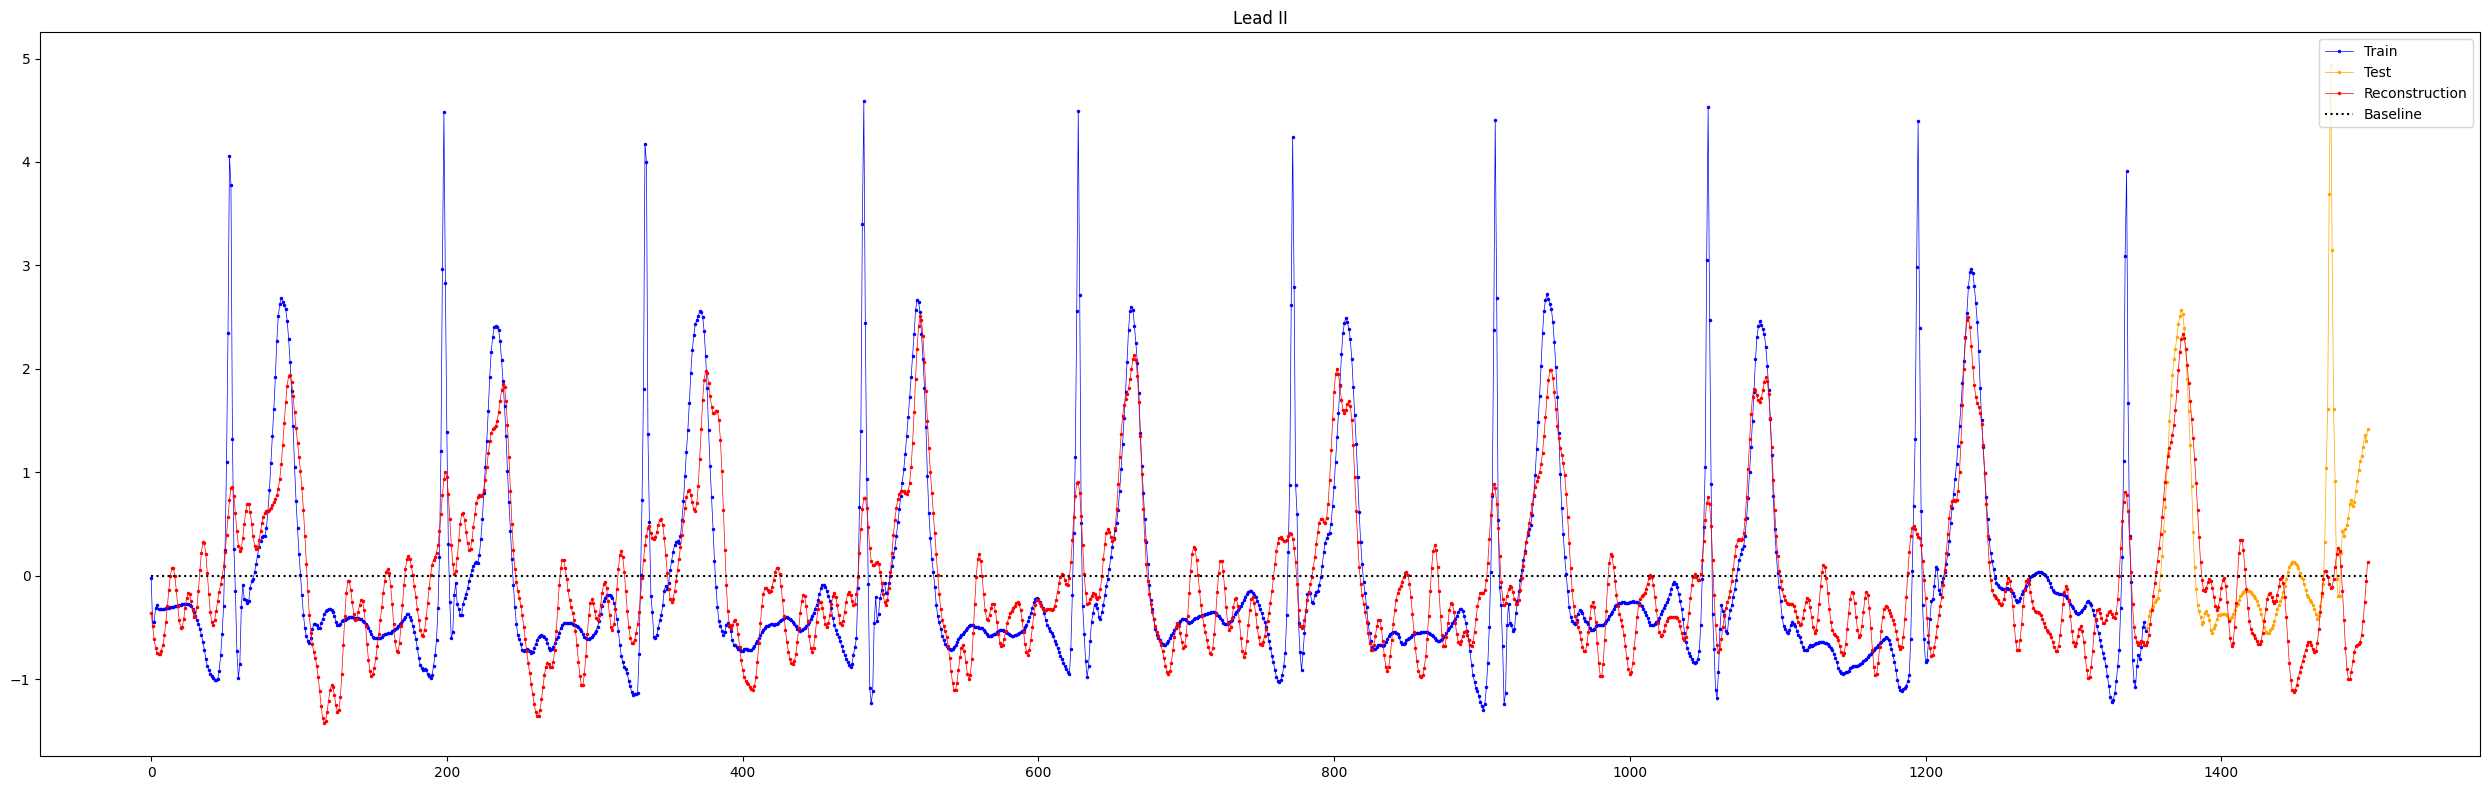

In [14]:
plt.figure(figsize=(25, 8))
plt.plot(range(fit_index), Y[:fit_index], '.-', c='blue', linewidth=0.5, markersize=3, label="Train")
plt.plot(range(fit_index, 1500), Y[fit_index:1500], '.-', c='orange', label='Test', linewidth=0.5, markersize=3)
plt.plot(rec, '.-', c="red", label='Reconstruction', linewidth=0.5, markersize=3)
plt.hlines(baseline, 0, len(Y), linestyles="dotted", colors="black", label="Baseline")
plt.title("Lead II")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f"resampled_standardised_denoised_ecg_forecast_m.pdf")
plt.show()

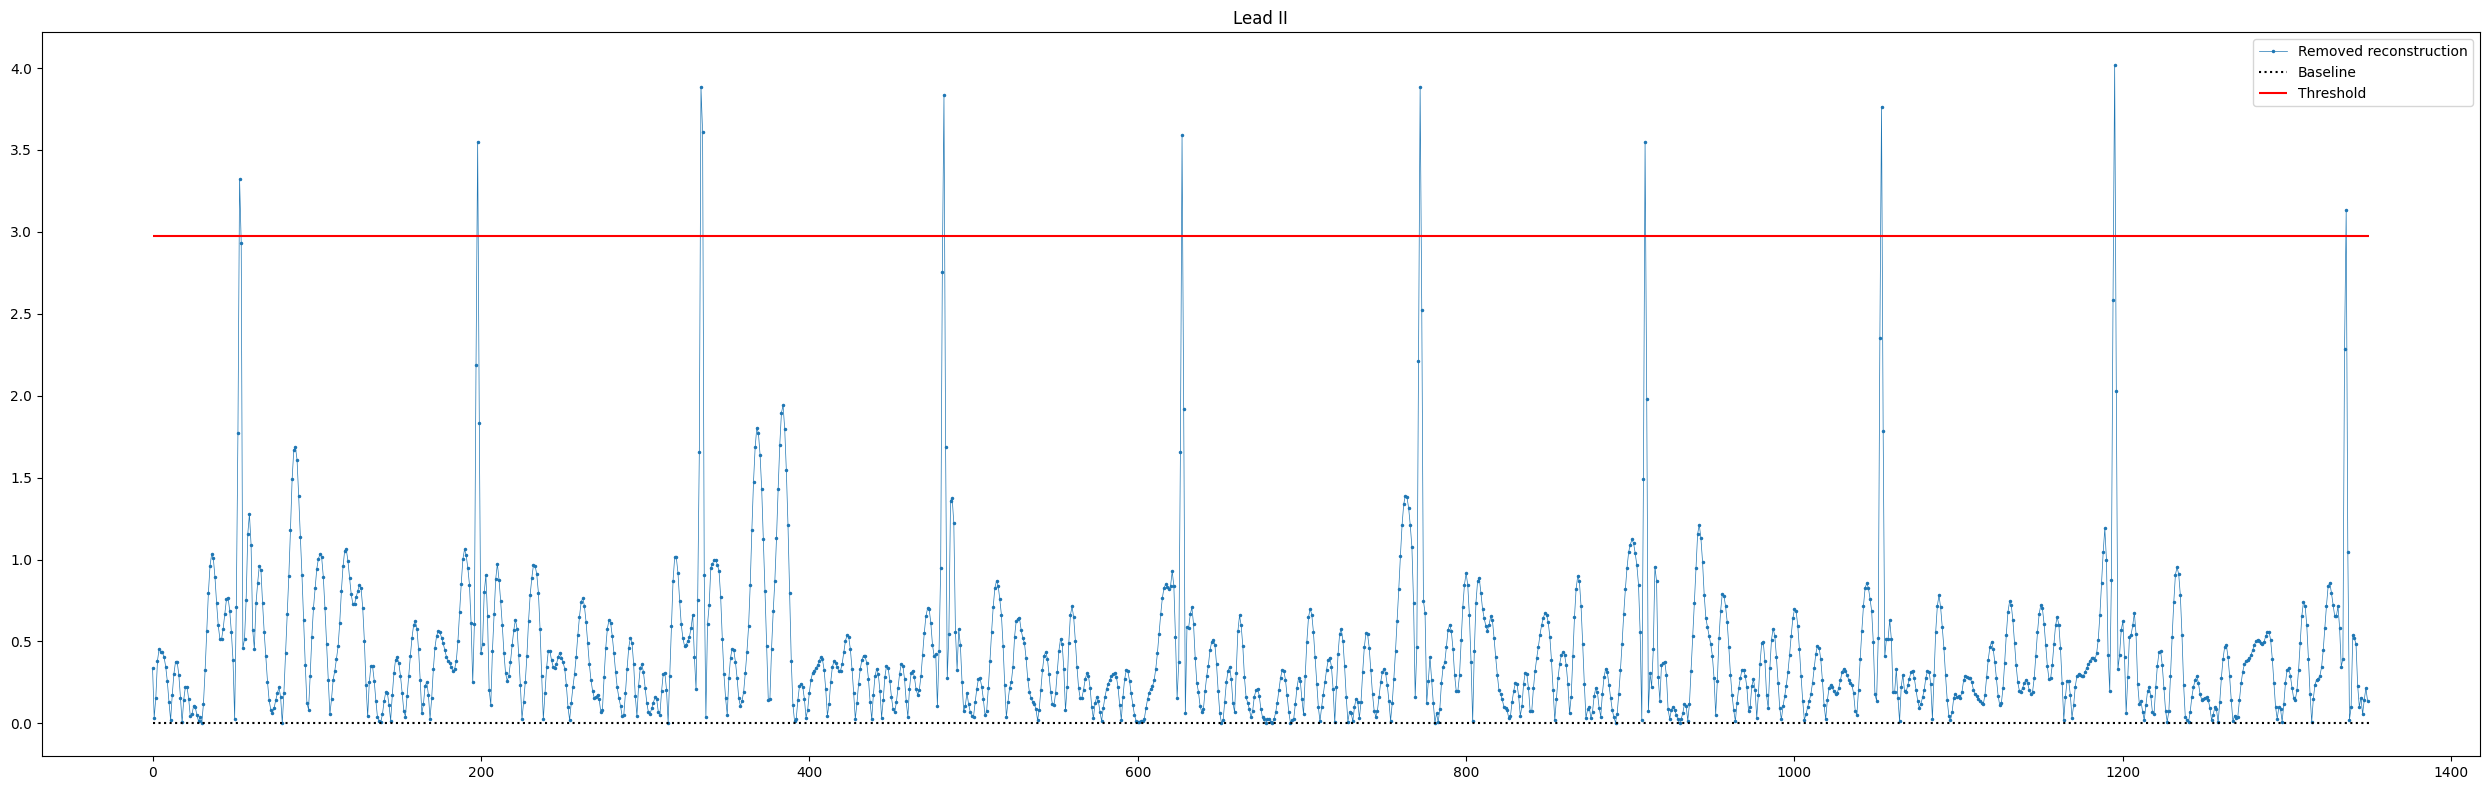

In [15]:
time = np.arange(fit_index)
plt.figure(figsize=(25, 8))
difference = np.abs(Y[:fit_index] - rec[:fit_index])
threshold = np.percentile(difference, 99.2)

plt.plot(time, difference, '.-', label='Removed reconstruction', linewidth=0.5, markersize=3)
plt.hlines(baseline, 0, fit_index, linestyles="dotted", colors="black", label="Baseline")
plt.hlines(threshold, 0, fit_index, linestyles="-", label="Threshold", colors="red")
# plt.hlines(threshold_baseline, 0, fit_index, linestyles="dotted", colors="red")
plt.title("Lead II")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f"resampled_standardised_denoised_ecg_rpeaks_algo_m.pdf")
plt.show()

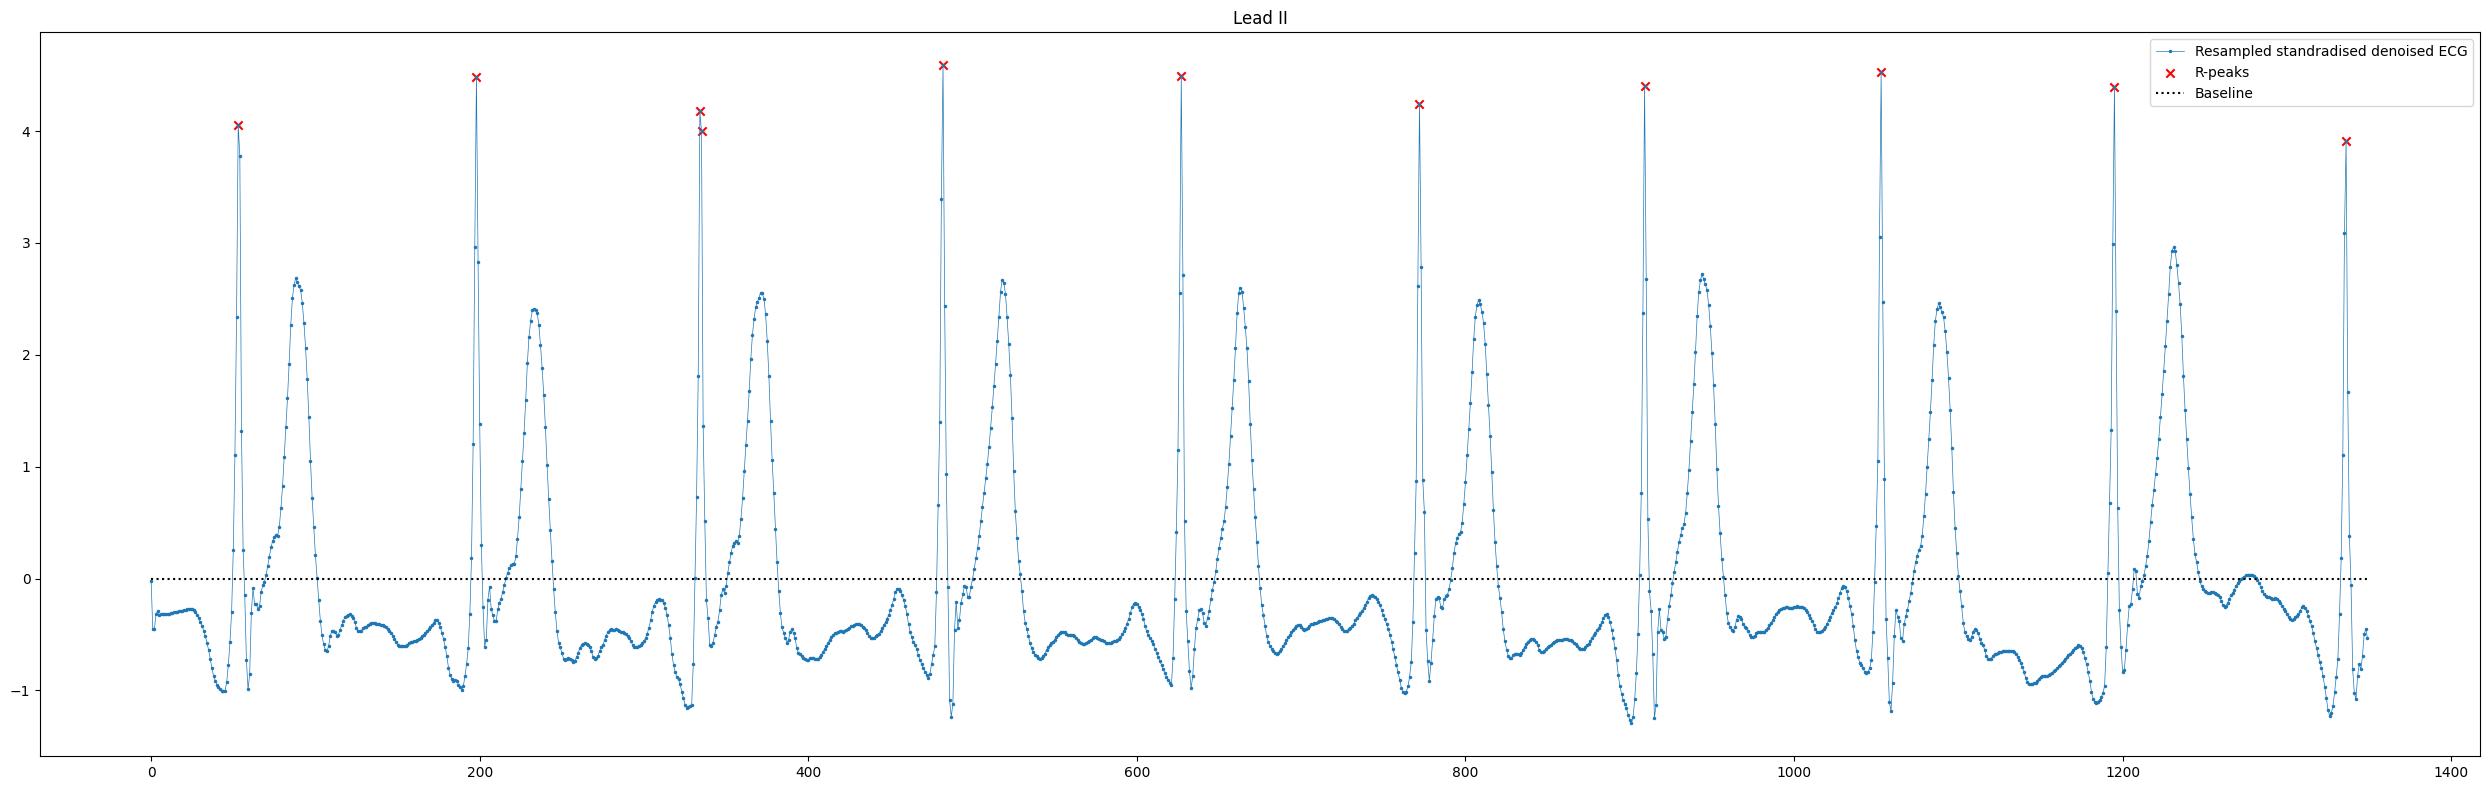

In [16]:
time = np.arange(fit_index)
plt.figure(figsize=(25, 8))
difference = np.abs(Y[:fit_index] - rec[:fit_index])
threshold = np.mean(np.percentile(difference, 99.2))

isolated_peaks = np.where((difference >= threshold), Y[:fit_index], 0)
non_zero_indices = isolated_peaks != 0
non_zero_times = time[non_zero_indices]
non_zero_peaks = isolated_peaks[non_zero_indices]
    
plt.plot(time, Y[:fit_index], '.-', label="Resampled standradised denoised ECG", linewidth=0.5, markersize=3)
plt.scatter(non_zero_times, non_zero_peaks, label='R-peaks', marker='x', c="r")
plt.hlines(baseline, 0, fit_index, linestyles="dotted", colors="black", label="Baseline")
plt.title("Lead II")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f"resampled_standardised_denoised_ecg_rpeaks_m.pdf")
plt.show()

In [17]:
# import numpy as np
# import scipy.signal as signal

# # Detect R-peaks
# peaks, _ = signal.find_peaks(Y, height=None, distance=150)

# # peaks contains the indices of the R-peaks in the signal
# print("R-peak indices:", peaks)

# # You can also get the R-peak values if needed
# r_peak_values = Y[peaks]
# print("R-peak values:", r_peak_values)

In [18]:
# original = pd.read_csv("beijing_temperature.csv", header=None).to_numpy()[1]
# original.shape

In [19]:
# import numpy as np
# import scipy.signal as signal
# import matplotlib.pyplot as plt

# # Example ECG data (replace this with your actual data)
# # Simulating a simple ECG signal with R-peaks
# time = np.linspace(0, 10, 5000)  # 10 seconds of data at 500 Hz

# # Detect R-peaks
# peaks, _ = signal.find_peaks(original, height=1, distance=200)

# # Plot the ECG signal with detected R-peaks
# plt.figure(figsize=(25, 8))
# plt.plot(time, original, label='ECG Signal')
# plt.plot(time[peaks], original[peaks], 'rx', label='Detected R-peaks')
# plt.title('ECG Signal with Detected R-peaks')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# # plt.legend()
# # plt.grid(True)
# plt.show()